# Using the IceNet API for the latest forecasts
This notebook will explain how to retrieve `IceNet` data from the public API and display it locally.

The forecasts are made on the central part (432x432) of the 720x720 [EASE2 5km grid](https://nsidc.org/ease/ease-grid-projection-gt) projections.
This means that the northern hemisphere uses the [EPSG:6931](https://epsg.io/6931) projection and the southern hemisphere uses [EPSG:6932](https://epsg.io/6932).

In [1]:
# Import required modules
import datetime
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

In [2]:
# Set the base URL for API requests
api_base_url = "https://app-icenetgeoapi-pygeoapi.azurewebsites.net/"

## Finding available datasets
In order to see which datasets are available we need to call the `collections` endpoint.

In [3]:
# Find out which collections are available
response = requests.get(f"{api_base_url}/collections")
collections = response.json()["collections"]
for collection in collections:
    print(f"{collection['id']}; {collection['title']}; {collection['description']}")

north_cells; Geometric grid cells (north); Northern hemisphere geometric grid cells
south_cells; Geometric grid cells (south); Southern hemisphere geometric grid cells
north_forecasts_latest; Latest forecasts (north); Most recent set of northern hemisphere sea ice concentration forecasts
south_forecasts_latest; Latest forecasts (south); Most recent set of southern hemisphere sea ice concentration forecasts
north_forecasts_historic; All forecasts (north); Historic northern hemisphere sea ice concentration forecasts
south_forecasts_historic; All forecasts (south); Historic southern hemisphere sea ice concentration forecasts


We can see that there are currently six collections available
- Northern hemisphere cells (`north_cells`): the EPSG:6931 grid geometries
- Southern hemisphere cells (`south_cells`): the EPSG:6932 grid geometries
- Northern hemisphere latest forecasts (`north_forecasts_latest`): latest sea ice concentration forecasts from the IceNet algorithm
- Southern hemisphere latest forecasts (`south_forecasts_latest`): latest sea ice concentration forecasts from the IceNet algorithm
- Northern hemisphere historic forecasts (`north_forecasts_historic`): sea ice concentration forecasts from older versions of the IceNet algorithm
- Southern hemisphere historic forecasts (`south_forecasts_historic`): sea ice concentration forecasts from older versions of the IceNet algorithm

## Find dataset attributes
The available attributes of the dataset can be found by calling the `queryables` endpoint.

In [4]:
# Find the list of queryables for northern hemisphere forecasts
response = requests.get(f"{api_base_url}/collections/north_forecasts_latest/queryables")
response.json()["properties"]

{'geometry': {'$ref': 'https://geojson.org/schema/Geometry.json'},
 'forecast_id': {'title': 'forecast_id', 'type': 'int8'},
 'date_forecast_generated': {'title': 'date_forecast_generated',
  'type': 'date'},
 'date_forecast_for': {'title': 'date_forecast_for', 'type': 'date'},
 'cell_id': {'title': 'cell_id', 'type': 'int4'},
 'sea_ice_concentration_mean': {'title': 'sea_ice_concentration_mean',
  'type': 'float4'},
 'sea_ice_concentration_stddev': {'title': 'sea_ice_concentration_stddev',
  'type': 'float4'}}

and here we can see the available columns that will be retrieved when a query is made

- `geometry` (the geometric shape for which the forecast was made)
- `forecast_id` (the ID of the forecast - only relevant for ensuring there are no duplicates)
- `date_forecast_generated` (the date when the forecast was made)
- `date_forecast_for` (which date the forecast was made for)
- `sea_ice_concentration_mean` (the mean of the IceNet forecast)
- `sea_ice_concentration_stddev` (the standard deviation of the IceNet forecast)

## Retrieving data
In order to retrieve one or more forecasts from the API we need to call the `items` endpoint.

In [5]:
# Get the latest available forecasts (limited to first 10 by default)
response = requests.get(f"{api_base_url}/collections/north_forecasts_latest/items")

In [6]:
# Take a look at the available features
response.json()["features"]

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-135, 16.4247079225175],
     [-135.132936604874, 16.623695732259],
     [-135, 16.8228850033408],
     [-134.867063395126, 16.623695732259],
     [-135, 16.4247079225175]]]},
  'properties': {'forecast_id': 1,
   'date_forecast_generated': '2022-02-17',
   'date_forecast_for': '2022-02-18',
   'cell_id': 1,
   'sea_ice_concentration_mean': 0.199749,
   'sea_ice_concentration_stddev': 0.398392},
  'id': 1},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-134.867063395126, 16.623695732259],
     [-135, 16.8228850033408],
     [-134.866443646294, 17.0213529826143],
     [-134.733509923942, 16.8219602213448],
     [-134.867063395126, 16.623695732259]]]},
  'properties': {'forecast_id': 2,
   'date_forecast_generated': '2022-02-17',
   'date_forecast_for': '2022-02-18',
   'cell_id': 2,
   'sea_ice_concentration_mean': 0.597203,
   'sea_ice_concentration_stddev': 0.482956},
  'id': 2},


## Retrieving all available data
Let's get the latest available forecasts (probably made today or yesterday) for a particular date in the future: we'll choose two weeks from today.

In [7]:
# Set the target date
target_date = (datetime.datetime.today() + datetime.timedelta(days=14)).date()
print(target_date)

2022-03-04


The API has a hard-coded limit on how long a query can take, so to retrieve large amounts of data we define a convenience function

In [8]:
# As Azure has a hard-coded 230s timeout we must retrieve the results in batches
def get_api_batches(base_url, batch_size):
    start_index, n_data_points = 0, batch_size
    responses = []
    # Retrieve 'batch_size' points, starting from where we ended the last batch
    # Terminate when there are fewer than 'batch_size' points returned - indicating the end of the dataset
    while n_data_points == batch_size:
        response = requests.get(f"{base_url}&startindex={start_index}&limit={batch_size}")
        n_data_points = len(response.json()["features"])
        responses.append(response)
        start_index += batch_size
        print(f"Loaded batch of {n_data_points} forecasts...")
    print(f"Finished: loaded {sum([len(r.json()['features']) for r in responses])} forecasts in total")
    return responses

In [9]:
# In order to retrieve all the results we keep making requests until the API stops returning new data
responses_north = get_api_batches(
    f"{api_base_url}/collections/north_forecasts_latest/items?date_forecast_for={target_date}",
    50000,
)

Loaded batch of 50000 forecasts...
Loaded batch of 47527 forecasts...
Finished: loaded 97527 forecasts in total


We have now retrieved data for all grid cells that have a non-zero forecast for sea-ice coverage.

## Loading into GeoPandas
Rather than looking at the JSON directly, it is probably better to deal with a library that understands GeoJSON.
In the rest of this example, we will use `geopandas`.

In [10]:
# Look at the first few rows of data
geodata_north = pd.concat([gpd.GeoDataFrame.from_features(r.json(), crs="EPSG:4326") for r in responses_north])
geodata_north.head()

,geometry,forecast_id,date_forecast_generated,date_forecast_for,cell_id,sea_ice_concentration_mean,sea_ice_concentration_stddev
0,"POLYGON ((-135.00000 16.42471, -135.13294 16.6...",1365379,2022-02-17,2022-03-04,1,0.266712,0.388724
1,"POLYGON ((-134.86706 16.62370, -135.00000 16.8...",1365380,2022-02-17,2022-03-04,2,0.799883,0.399941
2,"POLYGON ((-134.73351 16.82196, -134.86644 17.0...",1365381,2022-02-17,2022-03-04,3,0.799996,0.399984
3,"POLYGON ((-134.59934 17.01950, -134.73226 17.2...",1365382,2022-02-17,2022-03-04,4,0.601116,0.488534
4,"POLYGON ((-134.46454 17.21632, -134.59746 17.4...",1365383,2022-02-17,2022-03-04,5,0.600000,0.489898


Let's convert from `EPSG:4326` (World Geodetic System projection) to `EPSG:6931` (NSIDC EASE-Grid for the North Pole)

In [11]:
# Convert to EPSG:6931
geodata_north.to_crs(6931, inplace=True)
geodata_north.head()

,geometry,forecast_id,date_forecast_generated,date_forecast_for,cell_id,sea_ice_concentration_mean,sea_ice_concentration_stddev
0,"POLYGON ((-5400000.001 5400000.001, -5375000.0...",1365379,2022-02-17,2022-03-04,1,0.266712,0.388724
1,"POLYGON ((-5400000.001 5375000.001, -5375000.0...",1365380,2022-02-17,2022-03-04,2,0.799883,0.399941
2,"POLYGON ((-5400000.001 5350000.001, -5375000.0...",1365381,2022-02-17,2022-03-04,3,0.799996,0.399984
3,"POLYGON ((-5400000.001 5325000.001, -5375000.0...",1365382,2022-02-17,2022-03-04,4,0.601116,0.488534
4,"POLYGON ((-5400000.001 5300000.001, -5375000.0...",1365383,2022-02-17,2022-03-04,5,0.600000,0.489898


In [12]:
# Now let's do the same thing for the southern hemisphere
responses_south = get_api_batches(
    f"{api_base_url}/collections/south_forecasts_latest/items?date_forecast_for={target_date}",
    50000,
)
geodata_south = pd.concat(
    [gpd.GeoDataFrame.from_features(r.json(), crs="EPSG:4326").to_crs(6932) for r in responses_south]
)
geodata_south.head()

Loaded batch of 50000 forecasts...
Loaded batch of 50000 forecasts...
Loaded batch of 50000 forecasts...
Loaded batch of 3353 forecasts...
Finished: loaded 153353 forecasts in total


,geometry,forecast_id,date_forecast_generated,date_forecast_for,cell_id,sea_ice_concentration_mean,sea_ice_concentration_stddev
0,"POLYGON ((-5400000.001 1575000.000, -5375000.0...",2146943,2022-02-17,2022-03-04,154,0.771382,0.327183
1,"POLYGON ((-5400000.001 1550000.000, -5375000.0...",2146944,2022-02-17,2022-03-04,155,0.749444,0.334100
2,"POLYGON ((-5400000.001 1525000.000, -5375000.0...",2146945,2022-02-17,2022-03-04,156,0.741106,0.338866
3,"POLYGON ((-5400000.001 1500000.000, -5375000.0...",2146946,2022-02-17,2022-03-04,157,0.746626,0.335574
4,"POLYGON ((-5400000.001 1475000.000, -5375000.0...",2146947,2022-02-17,2022-03-04,158,0.751134,0.334430


## Plotting retrieved data
We can now plot this data on a world map.

In [13]:
# Load geometries for all world landmasses
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [14]:
# Construct a circle with radius 5400km centered on the North pole
boundary_north = gpd.GeoDataFrame(
    {"origin": [Point(0, 0)], "geometry": [Point(0, 0).buffer(5400 * 1000)]},
    crs="EPSG:6931",
)

In [15]:
# Select only those landmasses that intersect with the boundary (NB. we have to manually exclude Antarctica)
world_north = gpd.overlay(
    world.loc[world.continent != "Antarctica"].to_crs("EPSG:6931"),
    boundary_north,
    how="intersection",
)
geodata_north = gpd.overlay(geodata_north, boundary_north, how="intersection")

In [16]:
# ... and the same for the South Pole
boundary_south = gpd.GeoDataFrame(
    {"origin": [Point(0, 0)], "geometry": [Point(0, 0).buffer(5400 * 1000)]},
    crs="EPSG:6932",
)
world_south = gpd.overlay(world.to_crs("EPSG:6932"), boundary_south, how="intersection")
geodata_south = gpd.overlay(geodata_south, boundary_south, how="intersection")

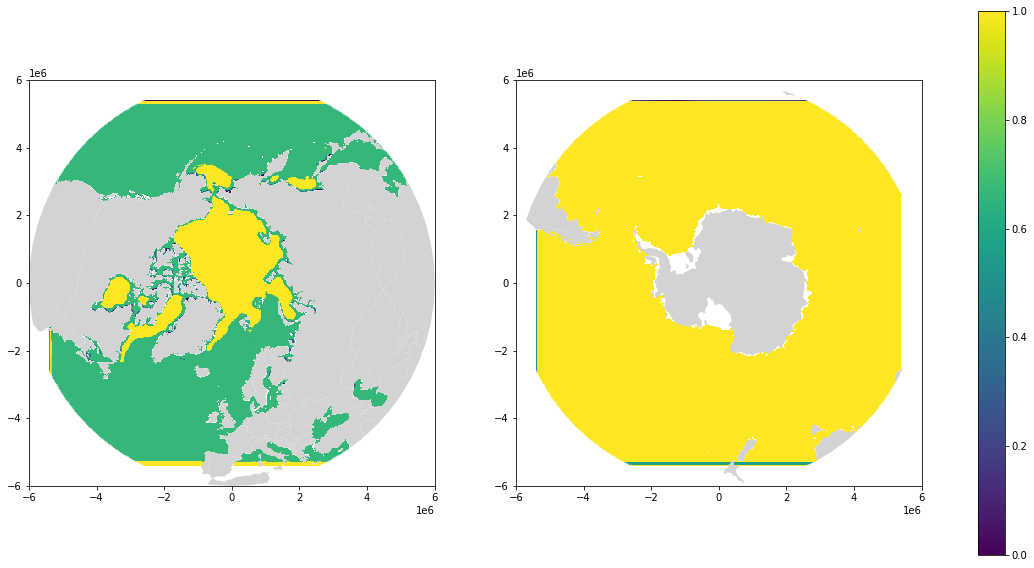

In [17]:
# Set up two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for axis in axes:
    axis.set(xlim=(-6e6, 6e6), ylim=(-6e6, 6e6))
    axis.set_aspect("equal", "box")

# Plot forecasts together with world map data
world_north.plot(ax=axes[0], color="lightgray")
geodata_north.plot(ax=axes[0], column="sea_ice_concentration_mean")
world_south.plot(ax=axes[1], color="lightgray")
geodata_south.plot(ax=axes[1], column="sea_ice_concentration_mean")

# Plot a single legend for both subplots
axes[0].collections[0].set_clim(0.0, 1.0)
legend = fig.colorbar(axes[0].collections[0], ax=axes)

You have now succesfully retrieved `IceNet` data from our API and plotted it on a world map. 🎉